# Loading Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import emoji

from IPython.display import Markdown as md
plt.style.use('ggplot')

In [2]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

# Loading Data

In [3]:
train_path = "../input/tweet-sentiment-extraction/train.csv"
test_path = "../input/tweet-sentiment-extraction/test.csv"
sample_submission_path = "../input/tweet-sentiment-extraction/sample_submission.csv"

In [4]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
submission = pd.read_csv(sample_submission_path)

# 1. Explore Data

In [5]:
df_train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


In [8]:
df_test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [9]:
print('Training data shape: ', df_train.shape)
print('Testing data shape: ', df_test.shape)

Training data shape:  (27481, 4)
Testing data shape:  (3534, 3)


# 2. Preprocessing

### 2-1) Missing Values treatment in the dataset

In [10]:
#Missing values in training set
df_train.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [11]:
#Missing values in test set
df_test.isnull().sum()

textID       0
text         0
sentiment    0
dtype: int64

In [12]:
#Drop missing value
df_train.dropna(axis = 0, how ='any',inplace=True) ;
df_test.dropna(axis = 0, how ='any',inplace=True) ;
df_train.isnull().sum()

textID           0
text             0
selected_text    0
sentiment        0
dtype: int64

In [13]:
df_train.to_csv('./train_v1.csv', index = False)
df_test.to_csv('./test_v1.csv', index = False)

# Preprocessing with one function

In [14]:
!pip install text-preprocessing
!pip install nltk

     |████████████████████████████████| 1.9 MB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.4 MB 18.5 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [15]:
!python -m pip install ../input/textpreprocessing/text_preprocessing-0.0.8-py2.py3-none-any.whl

Processing /kaggle/input/textpreprocessing/text_preprocessing-0.0.8-py2.py3-none-any.whl
  Attempting uninstall: text-preprocessing
    Found existing installation: text-preprocessing 0.0.9
    Uninstalling text-preprocessing-0.0.9:
      Successfully uninstalled text-preprocessing-0.0.9
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [16]:
import text_preprocessing
import string

!pip install contractions
import contractions

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

import string
punc = string.punctuation

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

nltk.download('averaged_perceptron_tagger')

nltk.download('wordnet')
from nltk.corpus import wordnet

from nltk.stem import WordNetLemmatizer

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
# text preprocessing helper functions

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = contractions.fix(text)
    return text


def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(tokenized_text)
    return combined_text

In [18]:
# Applying the cleaning function to both test and training datasets
#df_train['text_clean'] = df_train['text'].apply(str).apply(lambda x: text_preprocessing(x))

df_test['text_clean'] = df_test['text'].apply(str).apply(lambda x: text_preprocessing(x))
df_test.head()

,textID,text,sentiment,text_clean
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,last session of the day
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,shanghai is also really exciting precisely sky...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,recession hit veronique branquinho she has to ...
3,01082688c6,happy bday!,positive,happy bday
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,i like it


In [19]:
df_test.sample(frac=0.05)

,textID,text,sentiment,text_clean
2166,c6881ba0e1,Ghunghte Mein Chanda Hai Phir Bhi Hai Phela C...,neutral,ghunghte mein chanda hai phir bhi hai phela ch...
1474,2f2721c6fe,"`If I don`t believe in Him, why would He belie...",negative,if i do not believe in him why would he believ...
2822,e64a4d5361,"_r One of mine is a potential winner I think, ...",neutral,r one of mine is a potential winner i think co...
1478,14c6d8edd1,heyy terrence u should come to my school on M...,neutral,heyy terrence you should come to my school on ...
2416,53e1fc3b18,_tweets I wish I could be there to give you th...,neutral,tweets i wish i could be there to give you the...
...,...,...,...,...
3377,0145dc9e7c,Good morning my fellow tweeters,positive,good morning my fellow tweeters
654,e133dbdc62,But I really want a Sporebat pet.,neutral,but i really want a sporebat pet
3166,99fdaff40d,http://twitpic.com/4wi9p - playing with ethan....,positive,playing with ethan i love you baby
3294,7a1556637a,That`s alright. Add your egg and maybe some ...,positive,that is alright add your egg and maybe some so...


In [20]:
df_train.to_csv('./train_v1.csv', index = False)

In [21]:
df_test.to_csv('./test_v1.csv', index = False)

# Padding

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()

In [23]:
tokenizer.fit_on_texts(df_train['selected_text'])
encoded_train = tokenizer.texts_to_sequences(df_train['selected_text'])

tokenizer.fit_on_texts(df_test['text_clean'])
encoded_test = tokenizer.texts_to_sequences(df_test['text_clean'])

print(encoded_train, encoded_test)

[[1, 146, 19, 7030, 73, 1, 157, 46], [419, 71], [7031, 15], [344, 15, 536], [2610, 14], [94, 507, 7032, 117, 7033, 74, 7034, 4697, 13, 3, 132, 4698, 4699, 17, 1845], [67], [474, 580], [395, 14, 5], [220, 57, 24, 2611, 3037], [85, 92, 85, 1, 30, 2, 25, 2274, 1, 3038, 3, 2612, 41, 4700, 289, 1, 21, 159, 145, 39, 7, 674, 8, 345], [40], [7035], [262], [528, 528, 63, 3, 4701, 7036], [1241, 98, 1, 70, 2275], [696], [143], [7037], [1077, 24, 23, 16, 260, 5], [98, 7038, 1, 21, 18, 72, 1, 80, 5, 196, 121, 167, 127, 127], [475], [9, 627, 3, 243, 13, 121, 401, 170, 9, 4702, 308, 48], [291, 4703, 7, 521, 1, 248, 2276, 29, 675, 2, 355, 99, 409, 2, 3, 2613, 7039], [68, 1242, 1, 352, 628, 7040, 7041, 6, 10, 597, 1303, 7042, 221, 1176], [3, 389, 7043, 1078, 17, 7, 639, 9, 67, 64, 1597], [1, 21, 72], [33, 451], [67], [995, 61, 36, 23, 163, 45], [476, 3039], [80], [75, 18, 92, 13, 204, 1846, 13, 78, 410, 996], [259], [850, 1, 772, 370, 3, 380, 1, 21, 145, 301, 7, 132, 2, 222, 122, 138, 1, 80, 53, 292, 2

In [24]:
len(encoded_train)

27480

In [25]:
max_len_train = max(len(item) for item in encoded_train)
max_len_test = max(len(item) for item in encoded_test)
print(max_len_train, max_len_test)

#max_len: train, test equalize
max_len_train = 35
max_len_test = 35

35 33


In [26]:
for item in encoded_train:
    while len(item) < max_len_train:  
        item.append(0)

padded_np_train = np.array(encoded_train)

for item in encoded_test:
    while len(item) < max_len_test:  
        item.append(0)

padded_np_test = np.array(encoded_test)

#save
np.save('./padded_train.npy',padded_np_train)
np.save('./padded_test.npy',padded_np_test)

In [27]:
padded_np_train.shape

(27480, 35)

In [28]:
padded_np_test.shape

(3534, 35)

In [29]:
len(df_train['sentiment'])

27480

In [30]:
len(df_test['sentiment'])

3534

**from here

In [31]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical

In [32]:
padded_train=np.load('../input/final-data/padded_train.npy')
padded_test=np.load('../input/final-data/padded_test.npy')

In [33]:
df_train = pd.read_csv('../input/final-data/train_v1.csv')
df_test = pd.read_csv('../input/final-data/test_v1.csv')

In [34]:
df_train['sentiment'].shape

(27480,)

In [35]:
# Finding the number of labels
num_labels = len(set(df_train['sentiment']))
print(num_labels)

3


# Label Encoder

In [36]:
from sklearn.preprocessing import LabelEncoder
lb=LabelEncoder()
sent_train=lb.fit_transform(df_train['sentiment'])
sent_test=lb.fit_transform(df_test['sentiment'])

In [37]:
print(sent_train)

[1 0 0 ... 2 2 1]


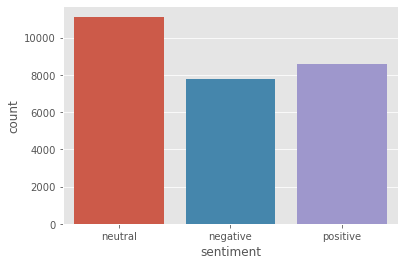

In [38]:
# Import the libraries
import seaborn as sns

sns.countplot(x='sentiment',data=df_train)

In [39]:
len(sent_train)

27480

In [40]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)

#train
sent_train = sent_train.reshape(len(sent_train), 1)
y_final = onehot_encoder.fit_transform(sent_train)

#test
sent_test = sent_test.reshape(len(sent_test), 1)
y_test = onehot_encoder.fit_transform(sent_test)

print(y_final.shape, y_test.shape)

(27480, 3) (3534, 3)


In [41]:
print(y_final)

[[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [42]:
x_final=padded_train
x_final.shape

(27480, 35)

In [43]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.33, random_state=42, shuffle=True)

# Build Model

In [44]:
np.unique(padded_train)

array([    0,     1,     2, ..., 17828, 17829, 17830])

In [45]:
np.unique(padded_test)

array([    0,     1,     2, ..., 20435, 20436, 20437])

In [46]:
len(np.unique(padded_test))

7046

In [47]:
voc_size=len(np.unique(padded_train))+1
print(voc_size)

17832


In [48]:
#hyperparameter
max_features = voc_size

embedding_dims = 300 # feature
max_len = 35 # time_step

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, LSTM, Dropout, Bidirectional

# Simple RNN (vanilla RNN)

In [50]:
def create_model():
    model = Sequential()
    # 2d_array (data, max_len)
    model.add(Embedding(voc_size, embedding_dims, input_length=max_len))
    # 3d_array (data, max_len, embedding_dims)
    model.add(SimpleRNN(32))
    # 2d_array (data, value)
    model.add(Dense(3, activation='softmax'))
    # 1d_array [0, 1, 0, 0, 1]
    
    model.compile(optimizer = 'adam', metrics=['accuracy'], loss = 'categorical_crossentropy')

    return model

In [51]:
model = create_model()

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 35, 300)           5349600   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                10656     
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 5,360,355
Trainable params: 5,360,355
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 10, batch_size = 64)

Epoch 1/10
288/288 [==============================] - 22s 75ms/step - loss: 0.7272 - accuracy: 0.7204 - val_loss: 0.6120 - val_accuracy: 0.7768
Epoch 2/10
288/288 [==============================] - 21s 73ms/step - loss: 0.5106 - accuracy: 0.8265 - val_loss: 0.5984 - val_accuracy: 0.7872
Epoch 3/10
288/288 [==============================] - 22s 77ms/step - loss: 0.4026 - accuracy: 0.8686 - val_loss: 0.6193 - val_accuracy: 0.7856
Epoch 4/10
288/288 [==============================] - 21s 73ms/step - loss: 0.3373 - accuracy: 0.8910 - val_loss: 0.6240 - val_accuracy: 0.7927
Epoch 5/10
288/288 [==============================] - 21s 72ms/step - loss: 0.2869 - accuracy: 0.9080 - val_loss: 0.6249 - val_accuracy: 0.7856
Epoch 6/10
288/288 [==============================] - 22s 77ms/step - loss: 0.2353 - accuracy: 0.9268 - val_loss: 0.6476 - val_accuracy: 0.7891
Epoch 7/10
288/288 [==============================] - 21s 72ms/step - loss: 0.2014 - accuracy: 0.9373 - val_loss: 0.6724 - val_accuracy:

In [54]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 10, batch_size = 512)

Epoch 1/10
36/36 [==============================] - 3s 90ms/step - loss: 0.1130 - accuracy: 0.9667 - val_loss: 0.7710 - val_accuracy: 0.7801
Epoch 2/10
36/36 [==============================] - 3s 80ms/step - loss: 0.0954 - accuracy: 0.9741 - val_loss: 0.7970 - val_accuracy: 0.7790
Epoch 3/10
36/36 [==============================] - 3s 79ms/step - loss: 0.0884 - accuracy: 0.9761 - val_loss: 0.8073 - val_accuracy: 0.7759
Epoch 4/10
36/36 [==============================] - 3s 79ms/step - loss: 0.0820 - accuracy: 0.9783 - val_loss: 0.8499 - val_accuracy: 0.7774
Epoch 5/10
36/36 [==============================] - 3s 88ms/step - loss: 0.0776 - accuracy: 0.9797 - val_loss: 0.8599 - val_accuracy: 0.7751
Epoch 6/10
36/36 [==============================] - 3s 90ms/step - loss: 0.0745 - accuracy: 0.9808 - val_loss: 0.8841 - val_accuracy: 0.7770
Epoch 7/10
36/36 [==============================] - 3s 88ms/step - loss: 0.0704 - accuracy: 0.9822 - val_loss: 0.8935 - val_accuracy: 0.7738
Epoch 8/10
36

# LSTM

In [55]:
from tensorflow.keras import regularizers

In [56]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os

checkpoint_path = "./cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = ModelCheckpoint(checkpoint_path, verbose=1, 
                              save_weights_only=True, period=1)

In [57]:
def create_lstm_model():
    model=Sequential()
    model.add(Embedding(voc_size, embedding_dims, input_length=max_len))
    model.add(LSTM(128))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

model_lstm = create_lstm_model()
print(model_lstm.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 35, 300)           5349600   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 5,569,635
Trainable params: 5,569,635
Non-trainable params: 0
_________________________________________________________________
None


In [58]:
history=model_lstm.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 10, batch_size = 512)

Epoch 1/10
36/36 [==============================] - 3s 78ms/step - loss: 0.9364 - accuracy: 0.5354 - val_loss: 0.7920 - val_accuracy: 0.6172
Epoch 2/10
36/36 [==============================] - 2s 63ms/step - loss: 0.7077 - accuracy: 0.6881 - val_loss: 0.6652 - val_accuracy: 0.7444
Epoch 3/10
36/36 [==============================] - 2s 67ms/step - loss: 0.5098 - accuracy: 0.8138 - val_loss: 0.6343 - val_accuracy: 0.7671
Epoch 4/10
36/36 [==============================] - 3s 75ms/step - loss: 0.4063 - accuracy: 0.8608 - val_loss: 0.6485 - val_accuracy: 0.7584
Epoch 5/10
36/36 [==============================] - 2s 68ms/step - loss: 0.3146 - accuracy: 0.8962 - val_loss: 0.6045 - val_accuracy: 0.7899
Epoch 6/10
36/36 [==============================] - 2s 66ms/step - loss: 0.2388 - accuracy: 0.9251 - val_loss: 0.5877 - val_accuracy: 0.8034
Epoch 7/10
36/36 [==============================] - 2s 64ms/step - loss: 0.1851 - accuracy: 0.9436 - val_loss: 0.6177 - val_accuracy: 0.7968
Epoch 8/10
36

In [59]:
loss, acc = model_lstm.evaluate(x_test,  y_test, verbose=2)

284/284 - 1s - loss: 0.7767 - accuracy: 0.7969


In [60]:
history1=model_lstm.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 20, batch_size = 512)

Epoch 1/20
36/36 [==============================] - 2s 65ms/step - loss: 0.1235 - accuracy: 0.9637 - val_loss: 0.7399 - val_accuracy: 0.8022
Epoch 2/20
36/36 [==============================] - 2s 64ms/step - loss: 0.1180 - accuracy: 0.9666 - val_loss: 0.7731 - val_accuracy: 0.7958
Epoch 3/20
36/36 [==============================] - 2s 68ms/step - loss: 0.1126 - accuracy: 0.9684 - val_loss: 0.7693 - val_accuracy: 0.7962
Epoch 4/20
36/36 [==============================] - 2s 62ms/step - loss: 0.1139 - accuracy: 0.9668 - val_loss: 0.8774 - val_accuracy: 0.7870
Epoch 5/20
36/36 [==============================] - 2s 65ms/step - loss: 0.1036 - accuracy: 0.9705 - val_loss: 0.8107 - val_accuracy: 0.7957
Epoch 6/20
36/36 [==============================] - 2s 63ms/step - loss: 0.0929 - accuracy: 0.9734 - val_loss: 0.9031 - val_accuracy: 0.7953
Epoch 7/20
36/36 [==============================] - 3s 79ms/step - loss: 0.0887 - accuracy: 0.9759 - val_loss: 0.8711 - val_accuracy: 0.7952
Epoch 8/20
36

In [61]:
import matplotlib.pyplot as plt

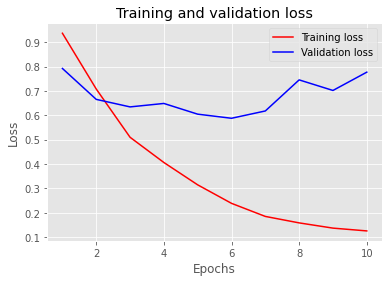

In [62]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()      

plt.show()

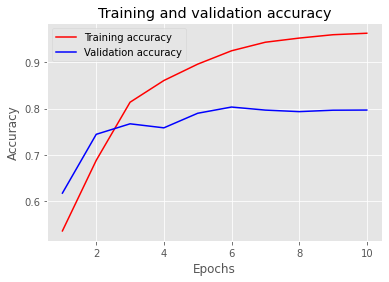

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'r', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [64]:
model_lstm.save('./save_model_lstm.h5')

# CNN+RNN

In [66]:
from tensorflow.keras.layers import Conv1D

In [67]:
def create_cnn_model():
    model = Sequential()
    model.add(Embedding(voc_size, embedding_dims, input_length=max_len))
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(35,1)))
    model.add(SimpleRNN(32))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer = 'adam', metrics=['accuracy'], loss = 'categorical_crossentropy')

    return model

In [ ]:
model_cnn = create_cnn_model()
print(model_cnn.summary())

In [ ]:
model_cnn.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 10, batch_size = 512)

# CNN+LSTM

In [ ]:
def create_cnnlstm_model():
    model=Sequential()
    model.add(Embedding(voc_size, embedding_dims, input_length=max_len))
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(35,1)))
    model.add(LSTM(100))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

model_cnnlstm = create_cnnlstm_model()
print(model_lstm.summary())

In [ ]:
model_cnnlstm.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 10, batch_size = 512)

load model

In [65]:
from keras.models import load_model
# load model from single file
model = create_lstm_model()
model_lstm = load_model('../input/weight/save_model_lstm.h5')